In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from utils import load_multi_traj_data
import model
import os
from matplotlib.patches import Ellipse

In [27]:
def visualize_ellipsoid(model, data_u):
	# Perform a PCA on the reshaped data, data is of size (num_traj, traj_length, traj_dim), we can lump all trajectory together into (traj_length, traj_dim)
	reshaped_data = data_u.reshape(-1, data_u.shape[-1])
	pca = PCA(n_components=2)
	pca_traj_1 = pca.fit_transform(reshaped_data)
	U = pca.components_

	# Get the ellipsoid parameters from the model
	# the ellipsoid of the model is expressed as V(x) = (x - x_0)^T Q (x - x_0) \leq c
	Q = model.V._construct_Q().detach().cpu().numpy()
	c = (model.c**2).detach().cpu().numpy().item()
	print(c)
	print(np.linalg.eigvals(Q))
	Q_inv = np.linalg.inv(Q)
	A = np.linalg.inv(U @ Q_inv @ U.T)

	# ----------------------------
	# Extract ellipse parameters from A:
	# The ellipse in PCA space is given by y^T A y = c.
	# Its semi-axis lengths are given by sqrt(c / eigenvalue).
	# The eigenvectors determine the orientation.
	# ----------------------------
	eigvals, eigvecs = np.linalg.eigh(A)
	print(eigvals)
	# Sort eigenvalues and eigenvectors in descending order.
	order = np.argsort(eigvals)[::-1]
	eigvals = eigvals[order]
	eigvecs = eigvecs[:, order]

	# Compute semi-axis lengths (for y^T A y = c)
	# print(eigvals)
	axis_length1 = np.sqrt(c / eigvals[0])
	axis_length2 = np.sqrt(c / eigvals[1])

	# Compute the rotation angle (in degrees) of the ellipse.
	angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))

	# ----------------------------
	# Plot the projected ellipsoid in the 2D PCA space.
	# ----------------------------
	fig, ax = plt.subplots(figsize=(10, 10))

	# For a centered ellipsoid, the projected center is U*(x0 - x0)=0.
	ellipse_patch = Ellipse(xy=(0, 0),
							width=2 * axis_length1,   # full axis length in the first direction
							height=2 * axis_length2,  # full axis length in the second direction
							angle=angle,
							edgecolor='red', facecolor='none', lw=2
							)
	ax.add_patch(ellipse_patch)

	# Optionally, plot the PCA-transformed trajectory data for context.
	ax.scatter(pca_traj_1[:, 0], pca_traj_1[:, 1], s=2, alpha=0.3, label="PCA GT")

	ax.set_xlabel('Component 1')
	ax.set_ylabel('Component 2')
	ax.legend()
	plt.axis('equal')

Using device: cuda
Loading data from Data/KS_data_batched_l100.53_grid512_M8_T500.0_dt0.01_amp5.0/data.npz...
Loaded validation dataset with 998 samples.
1
Projection layer included
Loading saved model weights from 0814_1657_project/model_epoch_best.pt...
0.6801539063453674
[ 2.00831871e+01  1.96254272e+01  1.68675346e+01  1.70028706e+01
  1.71022701e+01  1.94170876e+01  1.72945786e+01  1.73467388e+01
  1.73584747e+01  1.75415936e+01  1.75823345e+01  1.76463833e+01
  1.77269840e+01  1.77593174e+01  1.78740406e+01  1.93345146e+01
  1.92401447e+01  1.79935799e+01  1.81305695e+01  1.82213783e+01
  1.83961563e+01  1.83704052e+01  1.91211071e+01  1.90572834e+01
  1.90299664e+01  1.85503826e+01  1.89661484e+01  1.89469242e+01
  1.88957844e+01  1.89215202e+01  1.88202496e+01  1.86538544e+01
  1.86868725e+01  1.87554188e+01  1.87443123e+01  1.87214050e+01
  1.69036407e+01  1.66658802e+01  1.64861603e+01  1.63579826e+01
  1.63232231e+01  1.60021896e+01  1.59063015e+01  1.57902012e+01
  1.563636

/tmp/ipykernel_5152/772107527.py:33: RuntimeWarning: invalid value encountered in sqrt
  axis_length2 = np.sqrt(c / eigvals[1])


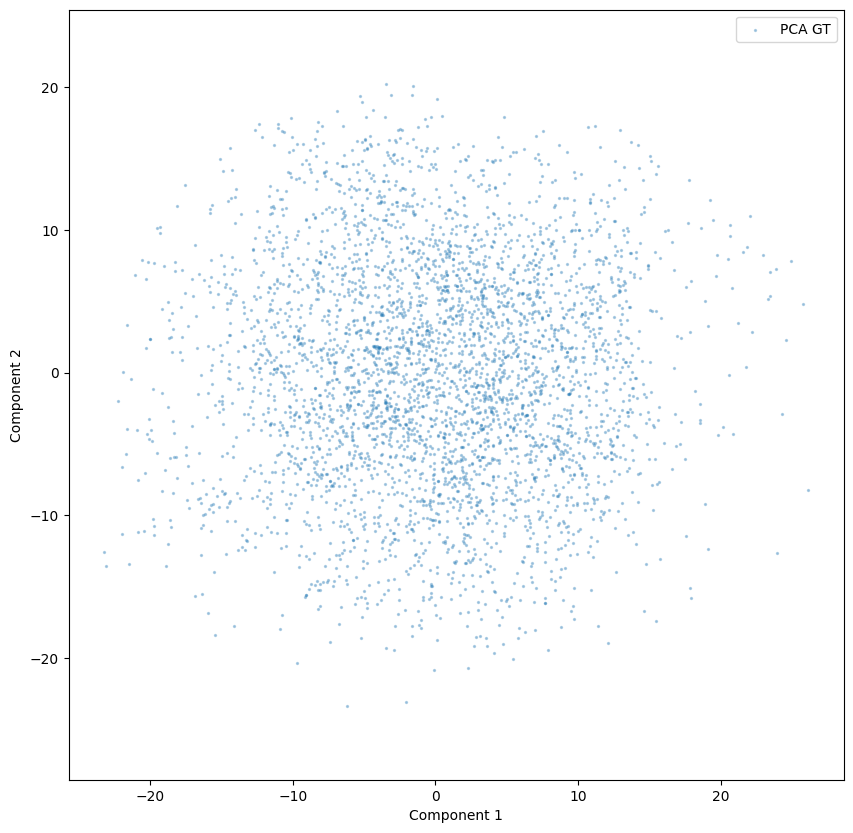

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tag = '0814_1657_project'
model_path = tag + '/model_epoch_best.pt' 
data_path = 'Data/KS_data_batched_l100.53_grid512_M8_T500.0_dt0.01_amp5.0/data.npz'
figs_folder = os.path.join(tag, 'eval_results')

if not os.path.exists(figs_folder):
	os.makedirs(figs_folder)

# --- 2. Load Data ---
print(f"Loading data from {data_path}...")
data = np.load(data_path, allow_pickle=True)
_, val_dataset = load_multi_traj_data(data)
print(f"Loaded validation dataset with {len(val_dataset)} samples.")

x_val = (val_dataset.branch_inputs.to(device), val_dataset.trunk_input.to(device))
y_val = val_dataset.targets.to(device)

# --- 3. Initialize and Load Model ---
m = val_dataset.branch_inputs.shape[1]
n = val_dataset.trunk_input.shape[1]
print(n)
project = True # Set this to match the config of the saved model

eval_model = model.DeepONet(m, n, project=project).to(device)
print(f"Loading saved model weights from {model_path}...")
eval_model.load_state_dict(torch.load(model_path, map_location=device))
eval_model.eval()

# --- 4. Run Visualization ---
visualize_ellipsoid(eval_model, data['u_batch'])

In [22]:
def plot_rollout_from_test_ic(model, x_test, s, rollout_steps, figs_dir='figs'):
    """
    Generates a long-term trajectory rollout starting from the first
    initial condition in the validation set.

    Args:
        model (torch.nn.Module): The trained DeepONet model.
        x_test (tuple): Test data tuple containing branch and trunk inputs.
        s (int): The spatial dimension size (grid size).
        rollout_steps (int): The number of time steps to predict.
        figs_dir (str): The directory where the output plot will be saved.
    """
    print("Generating rollout plot from a test initial condition...")
    model.eval()
    rollout_traj = torch.zeros(rollout_steps, s, device=x_test[0].device)
    
    # Extract the initial condition and the constant trunk input
    u_out = x_test[0][0, :].unsqueeze(0)
    trunk_input = x_test[1]

    with torch.no_grad():
        for i in range(rollout_steps):
            u_out = model((u_out, trunk_input))
            rollout_traj[i, :] = u_out.squeeze()

    plt.figure(figsize=(8, 4))
    plt.imshow(
        rollout_traj.T.detach().cpu().numpy(),
        aspect='auto', cmap='viridis'
    )
    plt.title(f'Rollout from Test IC ({rollout_steps} steps)')
    plt.xlabel('Time (steps)')
    plt.ylabel('Position')
    plt.colorbar(label='Value')
    plt.tight_layout()
    plt.savefig(f'{figs_dir}/2_rollout_from_test_ic.png', dpi=300)
    plt.close()

In [16]:
def plot_rollout_from_random_ic(model, trunk_input, s, rollout_steps, device, random_seed, figs_dir='figs'):
    """
    Generates a long-term trajectory rollout starting from a random
    initial condition.

    Args:
        model (torch.nn.Module): The trained DeepONet model.
        trunk_input (torch.Tensor): The constant trunk input.
        s (int): The spatial dimension size (grid size).
        rollout_steps (int): The number of time steps to predict.
        device (torch.device): The device to run the model on.
        random_seed (int): Seed for generating the random IC.
        figs_dir (str): The directory where the output plot will be saved.
    """
    print("Generating rollout plot from a random initial condition...")
    model.eval()
    torch.manual_seed(random_seed)
    
    rollout_traj = torch.zeros(rollout_steps, s, device=device)
    u_out = torch.randn(1, s, device=device) # Create random initial condition

    with torch.no_grad():
        for i in range(rollout_steps):
            u_out = model((u_out, trunk_input))
            rollout_traj[i, :] = u_out.squeeze()

    plt.figure(figsize=(8, 4))
    plt.imshow(
        rollout_traj.T.detach().cpu().numpy(),
        aspect='auto', cmap='viridis'
    )
    plt.title(f'Rollout from Random IC ({rollout_steps} steps)')
    plt.xlabel('Time (steps)')
    plt.ylabel('Position')
    plt.colorbar(label='Value')
    plt.tight_layout()
    plt.savefig(f'{figs_dir}/3_rollout_from_random_ic.png', dpi=300)
    plt.close()

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tag = '0814_1657_project'
model_path = tag + '/model_epoch_best.pt' 
data_path = 'Data/KS_data_batched_l100.53_grid512_M8_T500.0_dt0.01_amp5.0/data.npz'
figs_folder = os.path.join(tag, 'eval_results')

if not os.path.exists(figs_folder):
	os.makedirs(figs_folder)

# --- 2. Load Data ---
print(f"Loading data from {data_path}...")
data = np.load(data_path, allow_pickle=True)
_, val_dataset = load_multi_traj_data(data)
print(f"Loaded validation dataset with {len(val_dataset)} samples.")

x_val = (val_dataset.branch_inputs.to(device), val_dataset.trunk_input.to(device))
y_val = val_dataset.targets.to(device)

# --- 3. Initialize and Load Model ---
m = val_dataset.branch_inputs.shape[1]
n = val_dataset.trunk_input.shape[1]
print(n)
project = True # Set this to match the config of the saved model

eval_model = model.DeepONet(m, n, project=project).to(device)
print(f"Loading saved model weights from {model_path}...")
eval_model.load_state_dict(torch.load(model_path, map_location=device))

# --- 4. Run Visualization ---
visualize_ellipsoid(eval_model, data['u_batch'])

Using device: cuda
Loading data from Data/KS_data_batched_l100.53_grid512_M8_T500.0_dt0.01_amp5.0/data.npz...
Loaded validation dataset with 998 samples.
1
Projection layer included
Loading saved model weights from 0814_1657_project/model_epoch_best.pt...


AttributeError: 'NoneType' object has no attribute 'detach'